## Data Wrangling

This project is about wrangling, analyzing and visualizing data gathered from the twitter account called WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators are almost always greater than 10 such as 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage. 

We will start with gathering the data, assess it quality and tidiness and then clean it to create visualizations.

In [3]:
# Load Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import json
from datetime import datetime
import tweepy
from io import BytesIO
from PIL import Image
import time

In [4]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
# No of rows and columns
twitter_archive.shape

(2356, 17)

In [6]:
#Download image prediction file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [7]:
image_prediction.set_index("tweet_id")
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [9]:
import tweepy

consumer_key = 'secret_key'
consumer_secret = 'secret'
access_token = 'my_token'
access_secret = 'my_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [84]:
# List of tweets
df_tweets = []
# Error tweets
tweet_failure = []
# Time of execution
start = time.time()

#Add each available tweet json to df_tweets
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended',
                               wait_on_rate_limit = True, wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count']
        retweets = tweet['retweet_count']
        user_followers = tweet['user']['followers_count']
        date_time = tweet['created_at']
        
        df_tweets.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        tweet_failure.append(tweet_id)
# Calculate the time of excution
end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 _ [{'code

In [245]:
len(df_tweets), len(tweet_failure)

(2331, 25)

Total number of tweets: 2331

Number of tweets with error: 25

In [246]:
# Create DataFrame
tweets_before = pd.DataFrame(df_tweets, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'date_time'])
# Save the dataFrame
tweets_before.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [247]:
#read the dataframe
tweets = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweets

,tweet_id,favorites,retweets,user_followers,date_time
0,892420643555336193,36297,7725,8773574,2017-08-01 16:23:56
1,892177421306343426,31301,5718,8773574,2017-08-01 00:17:27
2,891815181378084864,23568,3786,8773574,2017-07-31 00:18:03
3,891689557279858688,39595,7888,8773574,2017-07-30 15:58:51
4,891327558926688256,37811,8506,8773574,2017-07-29 16:00:24
5,891087950875897856,19046,2851,8773574,2017-07-29 00:08:17
6,890971913173991426,11093,1855,8773574,2017-07-28 16:27:12
7,890729181411237888,61163,17242,8773574,2017-07-28 00:22:40
8,890609185150312448,26200,3924,8773574,2017-07-27 16:25:51
9,890240255349198849,29950,6718,8773574,2017-07-26 15:59:51


## Assess

In [248]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [249]:
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Lucy           11
Cooper         11
Lola           10
Tucker         10
Penny          10
Bo              9
Winston         9
the             8
Sadie           8
Bailey          7
an              7
Buddy           7
Toby            7
Daisy           7
Scout           6
Leo             6
Milo            6
Stanley         6
Rusty           6
Bella           6
Jack            6
Jax             6
Koda            6
Oscar           6
Dave            6
Larry           5
             ... 
Carbon          1
Julius          1
Livvie          1
Kane            1
Rizzo           1
Timber          1
Tupawc          1
Napolean        1
my              1
Norman          1
Karma           1
Crumpet         1
Schnitzel       1
Chef            1
Maks            1
Stuart          1
Amélie          1
Tessa           1
by              1
Stella          1
Pepper          1
Comet           1
Monty           1
Pippin          1
Strider   

In [250]:
#Statistical description
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [251]:
#Samples of the data
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
532,808001312164028416,NaN,NaN,2016-12-11 17:31:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He likes to stick his tongue o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808001312...,12,10,Cooper,None,None,None,None
2312,666776908487630848,NaN,NaN,2015-11-18 00:36:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Josep. He is a Rye Manganese mix. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,None,None,None,None
831,768609597686943744,NaN,NaN,2016-08-25 00:43:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. His sweater is too small and he a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768609597...,10,10,Lou,None,None,None,None
2174,669216679721873412,NaN,NaN,2015-11-24 18:11:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clarq. He's a golden Quetzalcoatl. Cla...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669216679...,8,10,Clarq,None,None,None,None
1690,681339448655802368,NaN,NaN,2015-12-28 05:02:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Asher. He's not wearing a seatbelt or ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681339448...,9,10,Asher,None,None,None,None


In [252]:
#No of names
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Lucy           11
Cooper         11
Lola           10
Tucker         10
Penny          10
Bo              9
Winston         9
the             8
Sadie           8
Bailey          7
an              7
Buddy           7
Toby            7
Daisy           7
Scout           6
Leo             6
Milo            6
Stanley         6
Rusty           6
Bella           6
Jack            6
Jax             6
Koda            6
Oscar           6
Dave            6
Larry           5
             ... 
Carbon          1
Julius          1
Livvie          1
Kane            1
Rizzo           1
Timber          1
Tupawc          1
Napolean        1
my              1
Norman          1
Karma           1
Crumpet         1
Schnitzel       1
Chef            1
Maks            1
Stuart          1
Amélie          1
Tessa           1
by              1
Stella          1
Pepper          1
Comet           1
Monty           1
Pippin          1
Strider   

In [253]:
#No of numerators
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [254]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [255]:
twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [256]:
twitter_archive.tweet_id.nunique()

2356

In [257]:
image_prediction.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [258]:
image_prediction.tail(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [259]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [260]:
image_prediction['tweet_id'].value_counts()

685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
776477788987613185    1
772114945936949249    1
699775878809702401    1
780858289093574656    1
700462010979500032    1
732726085725589504    1
738883359779196928    1
798644042770751489    1
743510151680958465    1
837012587749474308    1
833722901757046785    1
668620235289837568    1
842765311967449089    1
685315239903100929    1
673686845050527744    1
680473011644985345    1
666051853826850816    1
675853064436391936    1
693231807727280129    1
705475953783398401    1
829449946868879360    1
759923798737051648    1
667160273090932737    1
680934982542561280    1
743545585370791937    1
                     ..
794926597468000259    1
776113305656188928    1
825026590719483904    1
834209720923721728    1
775733305207554048    1
669564461267722241    1
879492040517615616    1
720775346191278080    1
666362758909284353    1
750506206503038976    1
6931556864910008

In [261]:
image_prediction['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
web_site                      19
Cardigan                      19
Maltese_dog                   18
teddy                         18
Eskimo_dog                    18
Shetland_sheepdog             18
beagle                        18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

## Assessing Summary

### Quality

1. Several datatypes are wrong and should be changed.
2. Numerator and denominator do not explain about the ratings properly and some values are unusual.
3. In several columns, null values are not treated as null values(like in case of names).
4. There are some invalid names (a, an and other names with 3 and less character).
5. The data also contains retweets which means there is duplicated data present.
6. Some columns have lots of null values.
7. There are many columns in this dataframe making it hard to read, and some will not be needed for analysis.
8. Some names starts with upper and some with lower character which means it is inconsistent.
9. Timestamp can be seperated into date and time columns.


### Tidiness

1. There are no need for some columns (doggo, floofer, pupper, puppo)
2. Merge 'tweet_info' and 'image_predictions' into 'twitter_archive'.

## Cleaning

Cleaning is the third step in our data wrangling process where we will fix the quality and tidiness issues found in the assessing stage.

#### Define

Change datatypes

#### Code

In [262]:
twitter_clean = twitter_archive.copy()
image_clean = image_prediction.copy()

In [263]:
#Change tweet_id to str and timestamp to datetime
twitter_clean.tweet_id = twitter_clean.tweet_id.astype(int)
twitter_clean.timestamp = pd.to_datetime(twitter_clean.timestamp, yearfirst = True)

#Change rating_numerator and rating_denominator to float.
twitter_clean.rating_numerator = twitter_clean.rating_numerator.astype(float)
twitter_clean.rating_denominator = twitter_clean.rating_numerator.astype(float)

#### Test

In [264]:
#Test
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[n

#### Define

We want only original ratings. Hence, we will delete the replies to tweets and retweeted tweets.

#### Code

In [265]:
twitter_clean[~twitter_clean.in_reply_to_status_id.isnull()].tweet_id.head()

30     886267009285017600
55     881633300179243008
64     879674319642796034
113    870726314365509632
148    863427515083354112
Name: tweet_id, dtype: int64

In [266]:
#dropping reply tweet
twitter_clean = twitter_clean[twitter_clean.in_reply_to_status_id.isnull()]

#dropping retweeted tweets
twitter_clean = twitter_clean[twitter_clean.retweeted_status_id.isnull()]

#dropping columns related to tweets that were retweeted or reply tweets
twitter_clean = twitter_clean.drop(labels = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                           'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1 )

#### Test

In [267]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 213.0+ KB


#### Define

Create a column for rating as ratings numerator and denominator do not give a proper picture.

#### Code

In [268]:
twitter_clean['rating'] = twitter_clean['rating_numerator'] / twitter_clean['rating_denominator']

#### Test

In [269]:
twitter_clean[['rating_numerator', 'rating_denominator', 'rating']].sample(5)

,rating_numerator,rating_denominator,rating
527,12.0,12.0,1.0
1322,11.0,11.0,1.0
365,13.0,13.0,1.0
1212,10.0,10.0,1.0
2297,10.0,10.0,1.0


We have got a new column called rating.

#### Define

Create a new column rating which can provide some insights about ratings.

#### Code

In [270]:
# Create a new dog column consisting of the stages
twitter_clean['dog_type'] = twitter_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')

#### Test

In [271]:
twitter_clean[['dog_type', 'doggo', 'floofer', 'pupper', 'puppo']].sample(10)

,dog_type,doggo,floofer,pupper,puppo
951,pupper,None,None,pupper,None
1365,NaN,None,None,None,None
205,NaN,None,None,None,None
1893,NaN,None,None,None,None
1240,NaN,None,None,None,None
72,NaN,None,None,None,None
968,NaN,None,None,None,None
1243,pupper,None,None,pupper,None
2287,NaN,None,None,None,None
1613,NaN,None,None,None,None


#### Define

Replace the names which makes no sense with NaN 


In [272]:
# Find all names that start with a lowercase letter
lower_names = []
for n in twitter_clean['name']:
    if n[0].islower() and n not in lower_names:
        lower_names.append(n)
        print(n)

such
a
quite
not
one
incredibly
very
my
his
an
actually
just
getting
mad
this
unacceptable
all
old
infuriating
the
by
officially
life
light
space


#### Code

In [273]:
# Replace all names that start with sense lowercasewhich makes no sense with a NaN
twitter_clean['name'].replace(lower_names, 
                        np.nan,
                       inplace = True)

# Replace all 'None's with a NaN
twitter_clean['name'].replace('None', 
                        np.nan,
                       inplace = True)

#### Test

In [274]:
twitter_clean['name'].value_counts()

Lucy              11
Charlie           11
Cooper            10
Oliver            10
Tucker             9
Penny              9
Lola               8
Sadie              8
Winston            8
Daisy              7
Toby               7
Bo                 6
Jax                6
Bailey             6
Koda               6
Stanley            6
Bella              6
Oscar              6
Louis              5
Milo               5
Scout              5
Buddy              5
Leo                5
Bentley            5
Chester            5
Dave               5
Rusty              5
Sophie             4
Oakley             4
Gus                4
                  ..
Blipson            1
Strider            1
Michelangelope     1
Bert               1
Robin              1
Barry              1
River              1
Timber             1
Rubio              1
Bloop              1
Lilly              1
Joshwa             1
Murphy             1
Freddery           1
Jo                 1
Emmy               1
Tonks        

All the names which made no sense have been replaced with NaN

#### Define
Date and time should be seperated 

#### Code

In [275]:
#using the apply function, applying the strftime function to each value of the timestamp column in each row
#https://stackoverflow.com/questions/35488036/using-lambda-and-strftime-on-dates-when-there-are-null-values-pandas
from datetime import datetime
twitter_clean['date'] = twitter_clean['timestamp'].apply(lambda x: x.strftime('%d-%m-%Y'))
twitter_clean['time'] = twitter_clean['timestamp'].apply(lambda x: x.strftime('%H:%M:%S'))

#changing datatype of the date column to datetime
twitter_clean.date = pd.to_datetime(twitter_clean.date, dayfirst = True)

#### Test

In [276]:
twitter_clean[['date','time']].sample(5)

,date,time
1730,2015-12-24,02:42:51
2010,2015-12-03,02:56:30
1803,2015-12-16,02:13:31
1911,2015-12-09,02:09:56
1503,2016-01-26,16:12:33


Hence, we have created new seperate columns for date and time.

### Tidiness

#### Define

Drop unneccessary colunms - As we have created one column for dog life stages, we can drop them to make data tidy.

#### Code

In [277]:
twitter_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [278]:
twitter_clean.head(4)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating,dog_type,date,time
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,13.0,Phineas,1.0,NaN,2017-08-01,16:23:56
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,13.0,Tilly,1.0,NaN,2017-08-01,00:17:27
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,12.0,Archie,1.0,NaN,2017-07-31,00:18:03
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,13.0,Darla,1.0,NaN,2017-07-30,15:58:51


We can see that the unwanted column has been removed.

#### Define
Create a complete dataframe merging twitter_clean, image_clean and tweets_clean

In [279]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id          2331 non-null int64
favorites         2331 non-null int64
retweets          2331 non-null int64
user_followers    2331 non-null int64
date_time         2331 non-null object
dtypes: int64(4), object(1)
memory usage: 91.1+ KB


#### Code

In [280]:
# merge twitter_clean with image_clean
complete_df = pd.merge(twitter_clean, image_clean, how = 'inner', on = ['tweet_id'])

# merge complete_df with tweets_clean
complete_df = pd.merge(complete_df, tweets, how = 'inner', on = ['tweet_id'])
# save the complete_df as csv
complete_df.to_csv('complete_df.csv', encoding = 'utf-8')

complete_df_clean = complete_df.copy()

#### Test

In [288]:
complete_df_clean['tweet_id'].duplicated().any()

False

In [290]:
complete_df.to_csv('twitter_archive_master.csv', index = False)

## Analysis and visualization

We can analyze the data and find some insights by creating a number of visualizations.

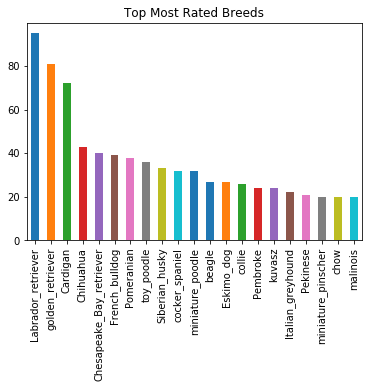

In [282]:
#Bar chart for top rated dogs
top=complete_df.groupby('p2').filter(lambda x: len(x) >= 20)
top['p2'].value_counts().plot(kind = 'bar')
plt.title('Top Most Rated Breeds');

We can observe that Labrador retriever and golden retriever are the top rated breeds of dog.

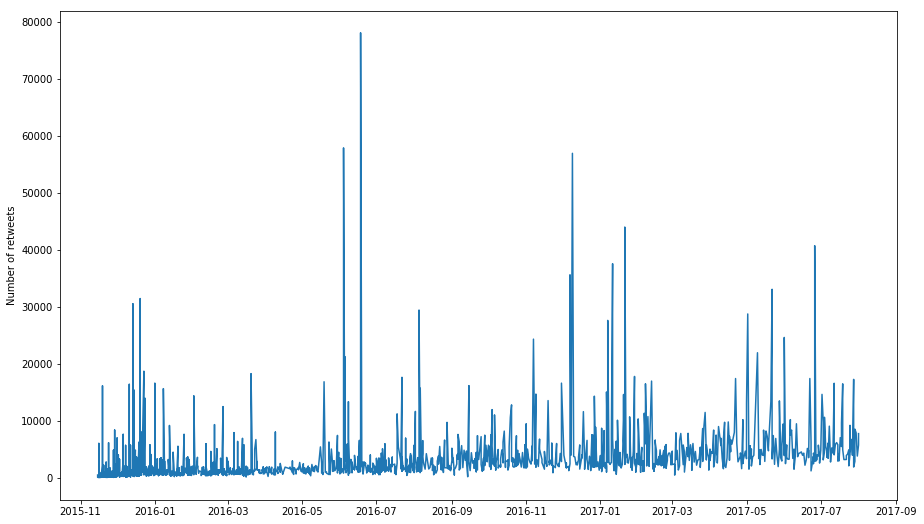

In [283]:
#Plotting retweets against time
sns.set_context()
plt.subplots(figsize=(15, 9))
plt.plot(complete_df.date, complete_df.retweets)
plt.ylabel("Number of retweets");

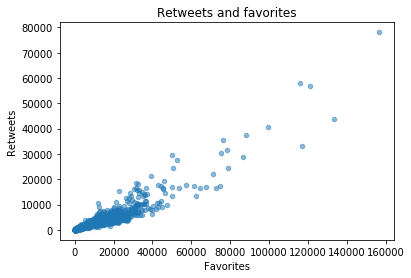

In [284]:
#scatter plots for the relationship of retweets and favorites
complete_df.plot(kind='scatter',x='favorites',y='retweets', alpha = 0.5)
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites');

There is a positive relation between favorites and retweets.

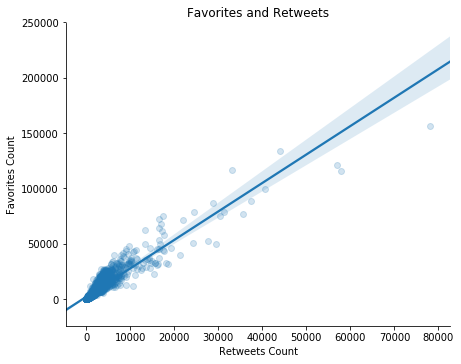

In [285]:
#plot for favorites and retweets
sns.lmplot(x="retweets", 
           y="favorites", 
           data=complete_df,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5})
plt.title('Favorites and Retweets')
plt.xlabel('Retweets Count')
plt.ylabel('Favorites Count');

According to the plot given above, we can confirm that there is a strong positive relation between favorites and retweets.

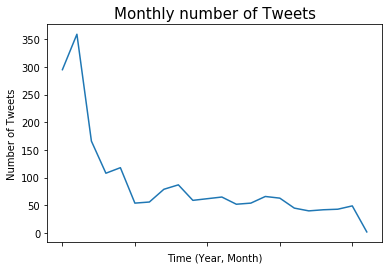

In [286]:
#Line chart for monthly tweets
selected_data = complete_df['tweet_id'].groupby([complete_df['timestamp'].dt.year, complete_df['timestamp'].dt.month]).count()
selected_data.plot('line')
plt.title('Monthly number of Tweets', size=15)
plt.xlabel('Time (Year, Month)')
plt.ylabel('Number of Tweets')
plt.savefig('number_of_tweets_over_time');

The number of tweets are falling along with the time for the twitter account.